You must catch them all.

In [15]:
import os
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from PIL import Image, ImageOps
from io import BytesIO
#from bunch import Bunch

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# from sklearn.model_selection import KFold
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.decomposition import PCA
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier



In [2]:
keras.__version__

'2.4.0'

In [3]:
tf.__version__

'2.4.1'

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
#Josh testing for tensorflow GPU usage______
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
image_size = (256, 256)

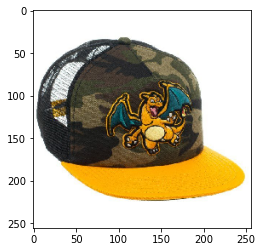

In [4]:
image_path = os.path.join("input/pokemon_images/Charizard/001d0fa5713a4b01b6a8772370d9bf98.jpg")
img = image.load_img(image_path, target_size=image_size)
plt.imshow(img)

Prepare a data pipeline

In [18]:
batch_size = 48
num_classes = 149 # this many classes of Pokemon in the dataset

data_generator = ImageDataGenerator(rescale=1./255,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    brightness_range=(0.5,1.5),
                                    rotation_range=10,
                                    validation_split=0.2) # use the `subset` argument in `flow_from_directory` to access

train_generator = data_generator.flow_from_directory('input/pokemon_images',
                                                    target_size=(160,160), # chosen because this is size of the images in dataset
                                                    batch_size=batch_size,
                                                    subset='training')

val_generator = data_generator.flow_from_directory('input/pokemon_images',
                                                    target_size=(160,160),
                                                    batch_size=batch_size,
                                                    subset='validation')


Found 8586 images belonging to 149 classes.
Found 2071 images belonging to 149 classes.


Transfer Learning

In [19]:
# import the base model and pretrained weights

custom_input = Input(shape=(160,160,3,))
base_model = InceptionV3(include_top=False, 
                         weights='imagenet', 
                         input_tensor=custom_input, 
                         input_shape=None, 
                         pooling=None, 
                         classes=num_classes)


In [20]:
x = base_model.layers[-1].output # snag the last layer of the imported model

x = GlobalMaxPooling2D()(x)
x = Dense(1024,activation='relu')(x) # an optional extra layer
x = Dense(num_classes,activation='softmax',name='predictions')(x) # our new, custom prediction layer

model = Model(inputs=base_model.input, outputs=x)
# new model begins from the beginning of the imported model,
# and the predictions come out of `x` (our new prediction layer)

# let's train all the layers
for layer in model.layers:
    layer.training = True

Optional: load pretrained model/weights

In [30]:
model = load_model('InceptionV3_Pokemon_redux.h5')


In [21]:
# these are utilities to maximize learning, while preventing over-fitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=12, cooldown=6, rate=0.6, min_lr=1e-18, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=24, verbose=1)

In [14]:
# compile and train the network
model.compile(optimizer=Adam(1e-8),loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_generator, 
          validation_data=val_generator, 
          steps_per_epoch=8586//batch_size, 
          validation_steps=2071//batch_size, 
          epochs=100, # increase this if actually training
          shuffle=True, 
          callbacks=[reduce_lr,early_stop] 
          )


Epoch 1/100


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[48,150] labels_size=[48,149]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at <ipython-input-14-afcfc8afadf4>:3) ]] [Op:__inference_train_function_31567]

Function call stack:
train_function


In [ ]:
# here's how to save the model after training. Use ModelCheckpoint callback to save mid-training.
model.save('InceptionV3_Pokemon_redux.h5')

In [27]:
# preprocessing and predicting function for test images:
def predict_this(this_img):
    im = this_img.resize((160,160)) # size expected by network
    img_array = np.array(im)
    img_array = img_array/255 # rescale pixel intensity as expected by network
    img_array = np.expand_dims(img_array, axis=0) # reshape from (160,160,3) to (1,160,160,3)
    pred = model.predict(img_array)
    return np.argmax(pred, axis=1).tolist()[0]

classes = [_class for _class in os.listdir('input/pokemon_images')]
classes.sort() # they were originally converted to number when loaded by folder, alphabetically

A wild Electrode appears!


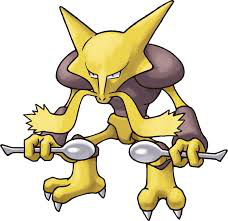

In [49]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQTGUl4Ab6gJXLMm7ZyaKi_EhJMPa4AiDukoQ&usqp=CAU'
response = requests.get(url)
img_1 = Image.open(BytesIO(response.content))

print("A wild {} appears!".format(classes[predict_this(img_1)]))
display(img_1)

A wild Electrode appears!


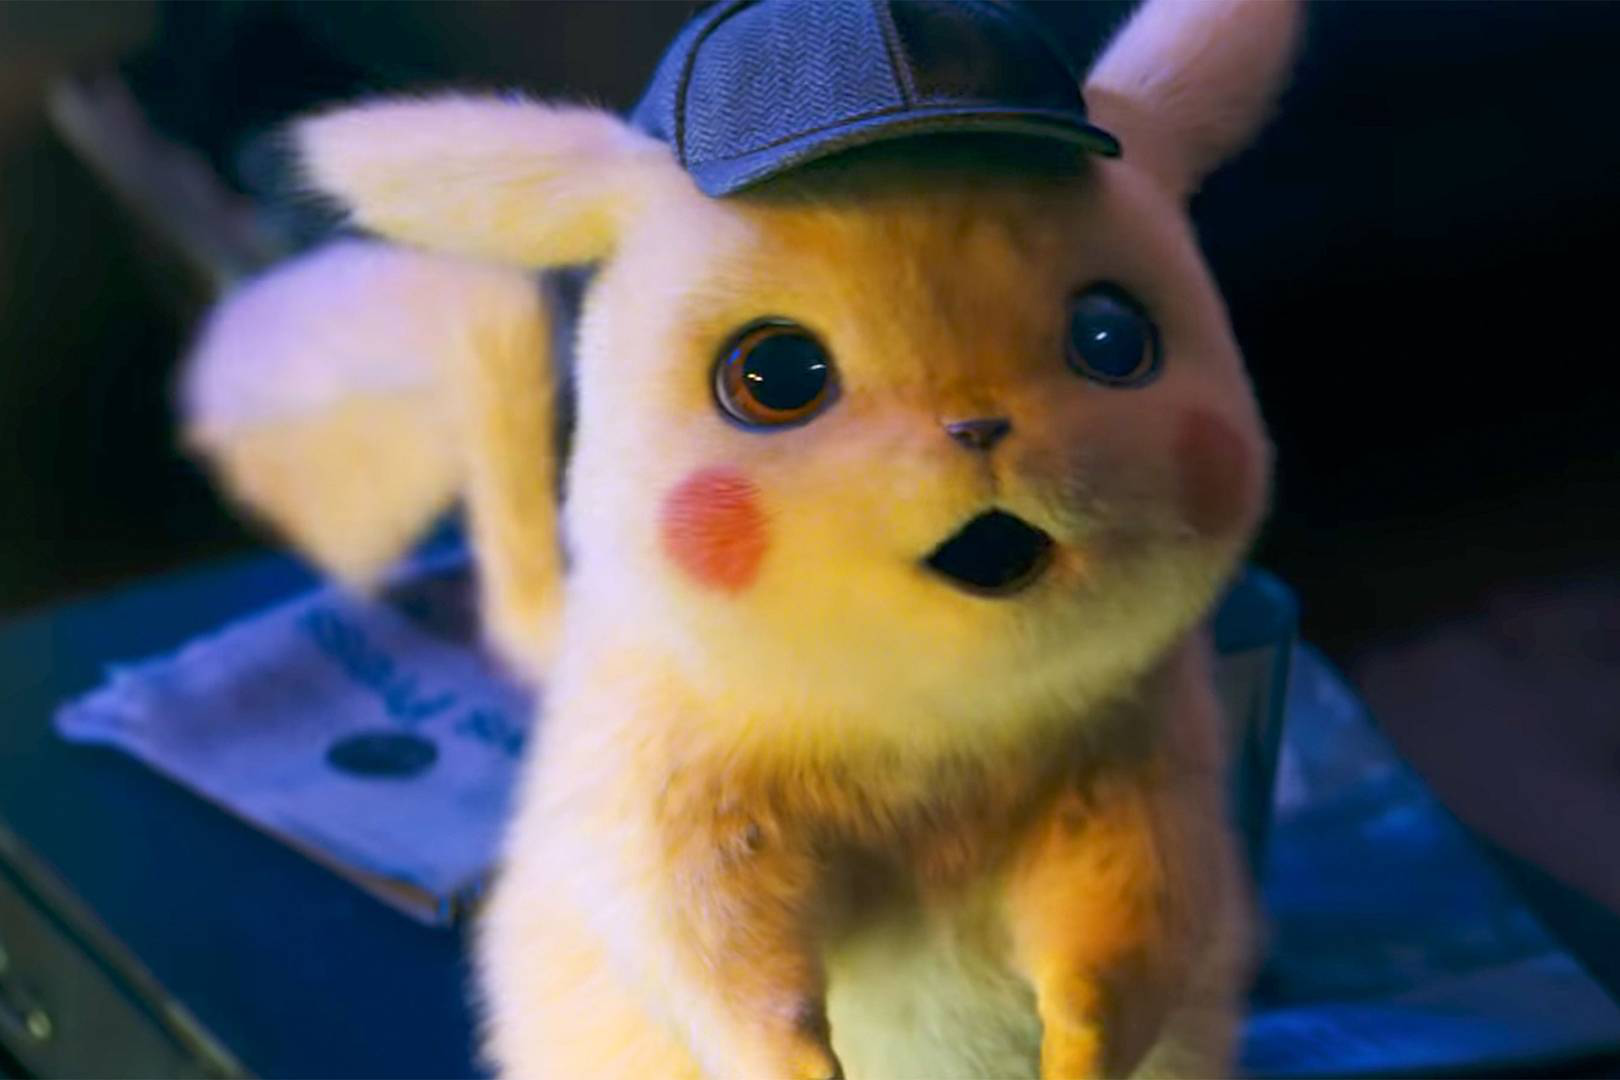

In [50]:
# the same thing, as a reusable function
def identify(url):
    response = requests.get(url)
    _img = Image.open(BytesIO(response.content))
    print("A wild {} appears!".format(classes[predict_this(_img)]))
    display(_img)

identify("https://bit.ly/2VQ32fd")

In [34]:
model.summary()

                 
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 8, 8, 192)    576         conv2d_68[0][0]                  
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 8, 8, 192)    576         conv2d_69[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 8, 8, 192)    0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
activation_63 (Activation)      (None, 8, 8, 192)    0           batch_normalization_63[0][0]     
__________________________________________________________________________________________________
activation_68 (Activation)      (None, 8, 8, 192)    0           batch_normalization_68[0][